[View in Colaboratory](https://colab.research.google.com/github/mogamin/dlllab-hackathon/blob/master/dllab_1st_hackathon_tutorial_image_classification2_with_cuda.ipynb)

In [24]:
!apt-get install -y -qq libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install cupy-cuda80==4.0.0b4 
!pip install chainer==4.0.0b4

import chainer

print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

GPU availability: True
cuDNN availablility: True


In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import chainer
import chainer.links as L
import chainer.functions as F

In [0]:
from chainer.datasets import get_cifar10
train, test = get_cifar10()

In [27]:
print(len(train))
print(len(test))

print(len(train[0]))
print(type(train[0][0]))
print(train[0][0].shape)


print(type(train[0][1]))
print(train[0][1].shape)
train[0][1]


50000
10000
2
<class 'numpy.ndarray'>
(3, 32, 32)
<class 'numpy.int32'>
()


6

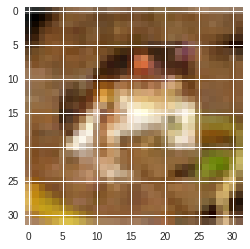

In [28]:
img = np.transpose(train[0][0], (1,2,0))
plt.imshow(img)

In [29]:
print(type(train[0][1]))
print(train[0][1].shape)
print(train[0][1].dtype)
train[0][1]

<class 'numpy.int32'>
()
int32


6

In [0]:
class Block(chainer.Chain):
  
  def __init__(self, out_channels, ksize, pad=1):
    super(Block, self).__init__()
    with self.init_scope():
      self.conv = L.Convolution2D(None, out_channels, ksize, pad=pad, nobias=True)
      self.bn = L.BatchNormalization(out_channels)
      
  def __call__(self, x):
    h = self.conv(x)
    h = self.bn(h)
    h = F.relu(h)
    return h
  

In [0]:
class VGG(chainer.Chain):
  
  def __init__(self, class_labels=10):
    super(VGG, self).__init__()
    with self.init_scope():
      self.block1_1 = Block(64,3)
      self.block1_2 = Block(64,3)

      self.block2_1 = Block(128,3)
      self.block2_2 = Block(128,3)

      self.block3_1 = Block(256,3)
      self.block3_2 = Block(256,3)
      self.block3_3 = Block(256,3)
      
      self.block4_1 = Block(512,3)
      self.block4_2 = Block(512,3)
      self.block4_3 = Block(512,3)
      
      self.block5_1 = Block(512,3)
      self.block5_2 = Block(512,3)
      self.block5_3 = Block(512,3)
      
      self.fc1 = L.Linear(None, 512, nobias=True)
      self.bn_fc1 = L.BatchNormalization(512)
      self.fc2 = L.Linear(None, class_labels, nobias=True)
      
  def __call__(self, x):
    
    # 64 bit channel blocks:
    h = self.block1_1(x)
    h = F.dropout(h, ratio=0.3)
    h = self.block1_2(h)
    h = F.max_pooling_2d(h, ksize=2, stride=2)
    
    # 128 bit channel blocks:
    h = self.block2_1(h)
    h = F.dropout(h, ratio=0.4)
    h = self.block2_2(h)
    h = F.max_pooling_2d(h, ksize=2, stride=2)
    
    # 256 bit channel blocks:
    h = self.block3_1(h)
    h = F.dropout(h, ratio=0.4)
    h = self.block3_2(h)
    h = F.dropout(h, ratio=0.4)
    h = self.block3_3(h)
    h = F.max_pooling_2d(h, ksize=2, stride=2)
    
    # 512 bit channel blocks:
    h = self.block4_1(h)
    h = F.dropout(h, ratio=0.4)
    h = self.block4_2(h)
    h = F.dropout(h, ratio=0.4)
    h = self.block4_3(h)
    h = F.max_pooling_2d(h, ksize=2, stride=2)
    
    # 512 bit channel blocks:
    h = self.block5_1(h)
    h = F.dropout(h, ratio=0.4)
    h = self.block5_2(h)
    h = F.dropout(h, ratio=0.4)
    h = self.block5_3(h)
    h = F.max_pooling_2d(h, ksize=2, stride=2)
    
    h = F.dropout(h, ratio=0.5)
    h = self.fc1(h)
    h = self.bn_fc1(h)
    h = F.relu(h)
    h = F.dropout(h, ratio=0.5)
    return self.fc2(h)     
      

In [0]:
import random
def reset_seed(seed=0):
  random.seed(seed)
  np.random.seed(seed)
  if chainer.cuda.available:
    chainer.cuda.cupy.random.seed(seed)


In [33]:
reset_seed(0)

model = L.Classifier(VGG())
optimizer = chainer.optimizers.MomentumSGD(0.05)
optimizer.setup(model)
#optimizer.add_hook(chainer.optimizer_hooks.WeightDecay(5e-4))


In [0]:
epoch = 50
batchsize = 512

from chainer import training
from chainer.training import extensions

# Iterator
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False ,shuffle=False)

# set up trainer
updater = training.StandardUpdater(train_iter, optimizer, device=0)
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result/cifar10')

trainer.extend(extensions.ExponentialShift('lr',0.5), trigger=(25,'epoch'))

trainer.extend(extensions.Evaluator(test_iter, model, device=0))
trainer.extend(extensions.dump_graph('main/loss'))
trainer.extend(extensions.snapshot(), trigger=(epoch,'epoch'))

trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch','elapsed_time','lr','main/loss','validation/main/loss','main/accuracy','validation/main/accuracy']))
trainer.extend(extensions.ProgressBar())
trainer.run()



epoch       elapsed_time  lr          main/loss   validation/main/loss  main/accuracy  validation/main/accuracy
1           186.11                    2.21344     2.70351               0.174944       0.11489                   
     total [#.................................................]  2.05%
this epoch [#.................................................]  2.40%
       100 iter, 1 epoch / 50 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
2           372.112                   1.88277     3.60802               0.25849        0.106778                  
     total [##................................................]  4.10%
this epoch [##................................................]  4.80%
       200 iter, 2 epoch / 50 epochs
   0.53735 iters/sec. Estimated time to finish: 2:25:14.654818.
3           556.366                   1.66266     3.38645               0.344052       0.159898                  
     total [###...............................................]  6.